# Desafío 1 — Análisis de 4 Tiendas (ENTREGA OFICIAL)

**Alumno:** David González  
**Fecha:** 2025-08-14

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Flacoca1970/Desafios_1/blob/main/AluraStoreLatam_Desafio_1_Entrega_Final_v3.ipynb)

> `<Flacoca1970>/<Desafios1>`

[Ver en GitHub](https://github.com/Flacoca1970/Desafios_1/blob/main/AluraStoreLatam_Desafio_1_Entrega_Final_v3.ipynb)

<a href="https://colab.research.google.com/github/flacoca/Proyecto_Prueba/blob/main/AluraStoreLatam_Desafio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Análisis de Tiendas del Sr. Juan
**Objetivo:** Determinar qué tienda vender para financiar un nuevo negocio, usando métricas de desempeño y satisfacción de clientes.


# 🎓 ENTREGA OFICIAL (1–5)

> Orden solicitado por el desafío. Cada punto es mandatorio, usa carga por **URL**, genera tablas formateadas y evidencia en `outputs/`.

## 0) Utilidades y carga por URL (mandatorio)

In [20]:

# URLs oficiales
url1 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

import pandas as pd, os, unicodedata
from IPython.display import display
os.makedirs("outputs", exist_ok=True)

# Carga idempotente
try:
    tienda, tienda2, tienda3, tienda4  # type: ignore
except NameError:
    tienda  = pd.read_csv(url1)
    tienda2 = pd.read_csv(url2)
    tienda3 = pd.read_csv(url3)
    tienda4 = pd.read_csv(url4)

# helpers de formato
def _miles(x):  # 1.234.567
    try:
        return f"{int(round(x)):,}".replace(",", ".")
    except Exception:
        return x

def _clp(x):    # $1.234.567
    try:
        return "$" + _miles(x)
    except Exception:
        return x


## 1) Análisis de facturación

,Tienda,Facturacion_Total,N_Ventas,Ticket_Promedio
0,Tienda 1,$1.150.880.400,2.359,$487.868
1,Tienda 2,$1.116.343.500,2.359,$473.227
2,Tienda 3,$1.098.019.600,2.359,$465.460
3,Tienda 4,$1.038.375.700,2.358,$440.363


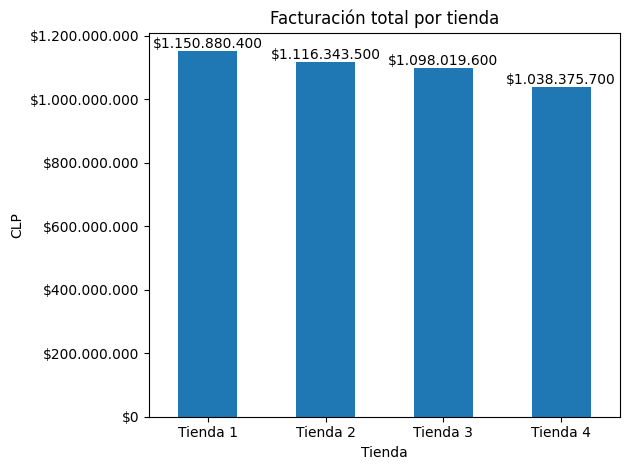

In [21]:

import numpy as np
def analisis_facturacion(df):
    total = pd.to_numeric(df['Precio'], errors='coerce').sum(skipna=True)
    n_ventas = pd.to_numeric(df['Precio'], errors='coerce').notna().sum()
    ticket = total / n_ventas if n_ventas else np.nan
    return total, n_ventas, ticket

rows = []
for nombre, dfx in {"Tienda 1":tienda, "Tienda 2":tienda2, "Tienda 3":tienda3, "Tienda 4":tienda4}.items():
    total, n, ticket = analisis_facturacion(dfx)
    rows.append({"Tienda":nombre, "Facturacion_Total": total, "N_Ventas": n, "Ticket_Promedio": ticket})

resumen_facturacion = (pd.DataFrame(rows)
                       .sort_values("Facturacion_Total", ascending=False)
                       .reset_index(drop=True))

# Mostrar SOLO tabla formateada
display(
    resumen_facturacion
      .assign(Facturacion_Total=lambda d: d["Facturacion_Total"].round(0).map(_clp),
              N_Ventas=lambda d: d["N_Ventas"].round(0).map(_miles),
              Ticket_Promedio=lambda d: d["Ticket_Promedio"].round(0).map(_clp))
)

# Evidencia CSV + gráfico
resumen_facturacion.to_csv("outputs/facturacion_total.csv", index=False)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def clp_fmt(x, pos=None):
    try: return "$" + f"{int(x):,}".replace(",", ".")
    except: return x

fig, ax = plt.subplots()
(resumen_facturacion.sort_values('Facturacion_Total', ascending=False)
 .plot(kind='bar', x='Tienda', y='Facturacion_Total', legend=False, ax=ax))
ax.set_title('Facturación total por tienda')
ax.set_xlabel('Tienda'); ax.set_ylabel('CLP')
ax.yaxis.set_major_formatter(FuncFormatter(clp_fmt))
ax.set_xticklabels(resumen_facturacion['Tienda'], rotation=0)
for c in ax.containers: ax.bar_label(c, labels=[clp_fmt(v) for v in c.datavalues])
plt.tight_layout(); plt.savefig("outputs/facturacion_total.png", bbox_inches="tight"); plt.show()


## 2) Ventas por categoría (Top 5 por tienda)

,Tienda 1,Tienda 2,Tienda 3,Tienda 4
Categoría del Producto,,,,
Muebles,465,442,499,480
Electrónicos,448,422,451,451
Juguetes,324,313,315,338
Electrodomésticos,312,305,278,254
Deportes y diversión,284,275,277,277


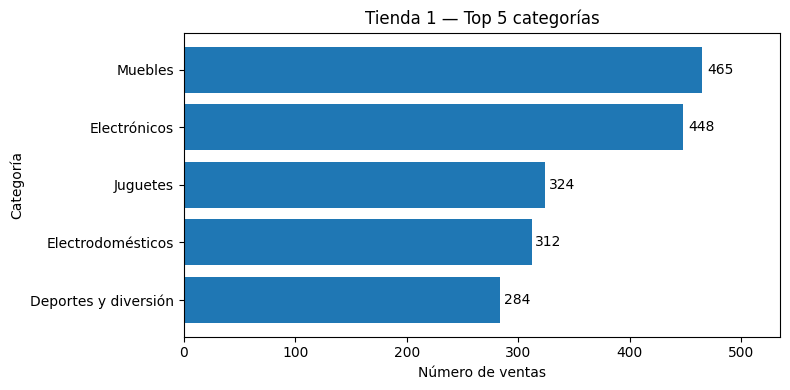

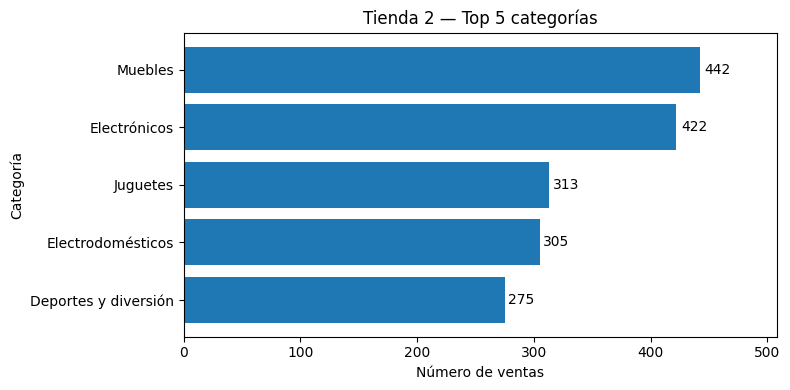

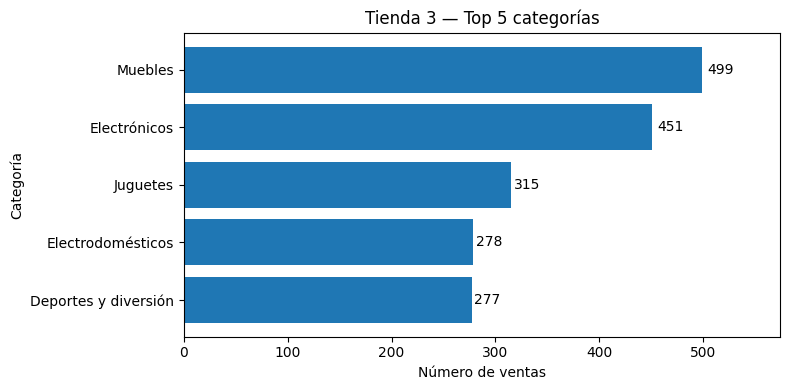

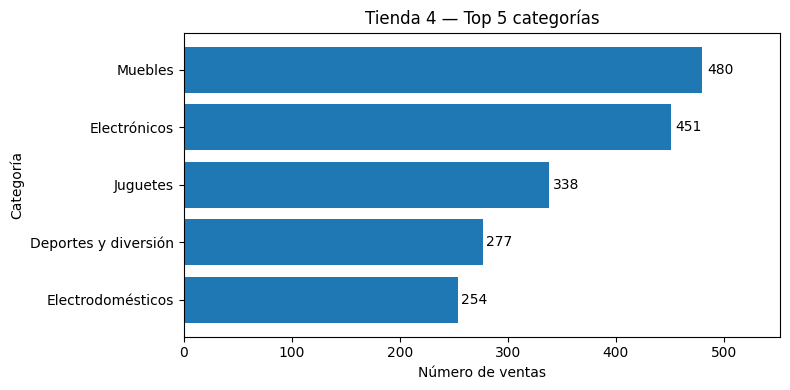

In [22]:

import matplotlib.pyplot as plt
from collections import OrderedDict

stores = [tienda, tienda2, tienda3, tienda4]

# Consolidado conteos Top 5 por tienda
cat_tables = []
for i, df in enumerate(stores, start=1):
    top5 = (df['Categoría del Producto'].astype(str).str.strip().value_counts().head(5))
    cat_tables.append(top5.rename(f"Tienda {i}"))

categorias_consolidado = pd.concat(cat_tables, axis=1).fillna(0).astype(int)
display(categorias_consolidado)
categorias_consolidado.to_csv("outputs/categorias_top5_consolidado.csv")

# Gráfico por tienda (PNG) con etiquetas fuera
from matplotlib.ticker import FuncFormatter
for i, df in enumerate(stores, start=1):
    top5 = (df['Categoría del Producto'].astype(str).str.strip().value_counts().head(5).sort_values())
    fig, ax = plt.subplots(figsize=(8,4))
    bars = ax.barh(top5.index, top5.values)
    ax.set_title(f"Tienda {i} — Top 5 categorías"); ax.set_xlabel("Número de ventas"); ax.set_ylabel("Categoría")
    xmax = top5.values.max()*1.15 if len(top5) else 1; ax.set_xlim(0, xmax)
    for bar, val in zip(bars, top5.values): ax.text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    plt.tight_layout(); plt.savefig(f"outputs/tienda_{i}_categorias_top5.png", bbox_inches="tight"); plt.show()


## 3) Calificación promedio de la tienda

,Tienda,Calificacion_Promedio
0,Tienda 3,4.048326
1,Tienda 2,4.037304
2,Tienda 4,3.995759
3,Tienda 1,3.976685


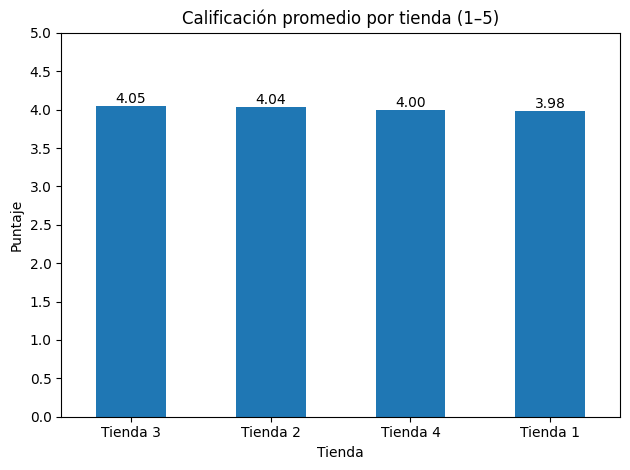

In [23]:

promedios = []
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    prom = pd.to_numeric(df['Calificación'], errors='coerce').mean(skipna=True)
    promedios.append({"Tienda": f"Tienda {i}", "Calificacion_Promedio": prom})

promedios_calificacion = (pd.DataFrame(promedios)
                          .sort_values('Calificacion_Promedio', ascending=False)
                          .reset_index(drop=True))
display(promedios_calificacion)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots()
promedios_calificacion.plot(kind='bar', x='Tienda', y='Calificacion_Promedio', legend=False, ax=ax)
ax.set_title('Calificación promedio por tienda (1–5)'); ax.set_xlabel('Tienda'); ax.set_ylabel('Puntaje')
ax.set_ylim(0,5); ax.set_xticklabels(promedios_calificacion['Tienda'], rotation=0); ax.yaxis.set_major_locator(MultipleLocator(0.5))
for c in ax.containers: ax.bar_label(c, fmt='%.2f')
plt.tight_layout(); plt.savefig("outputs/calificacion_promedio.png", bbox_inches="tight"); plt.show()

promedios_calificacion.to_csv("outputs/promedios_calificacion.csv", index=False)


## 4) Productos más y menos vendidos (Top/Bottom 5)

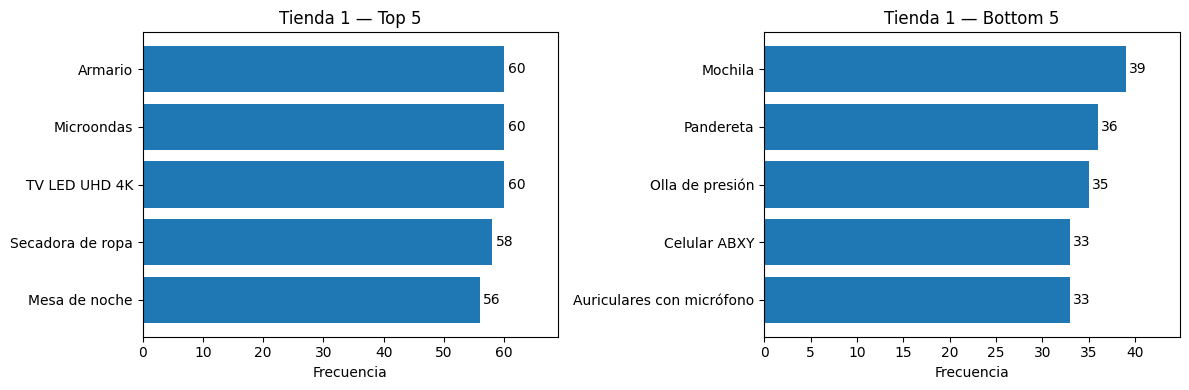

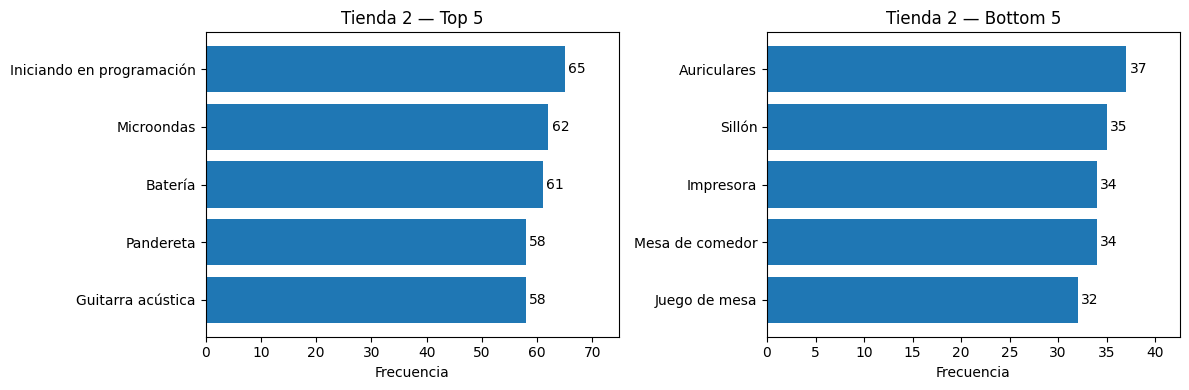

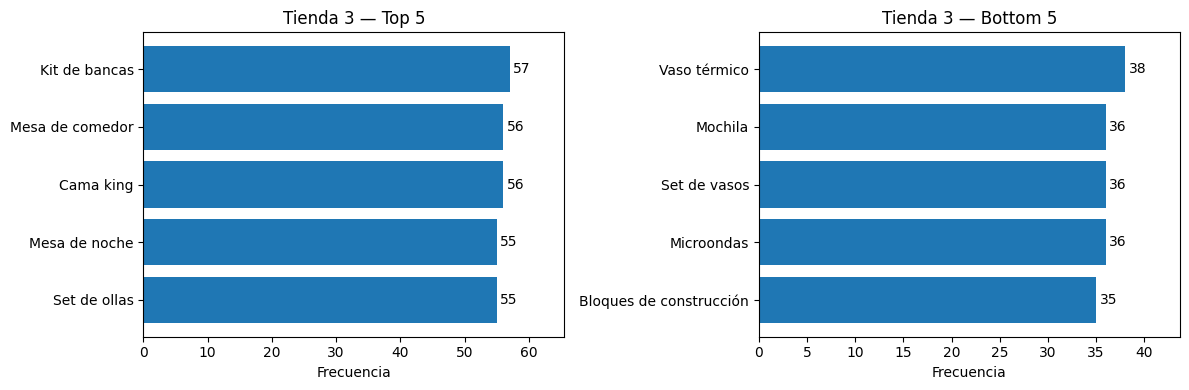

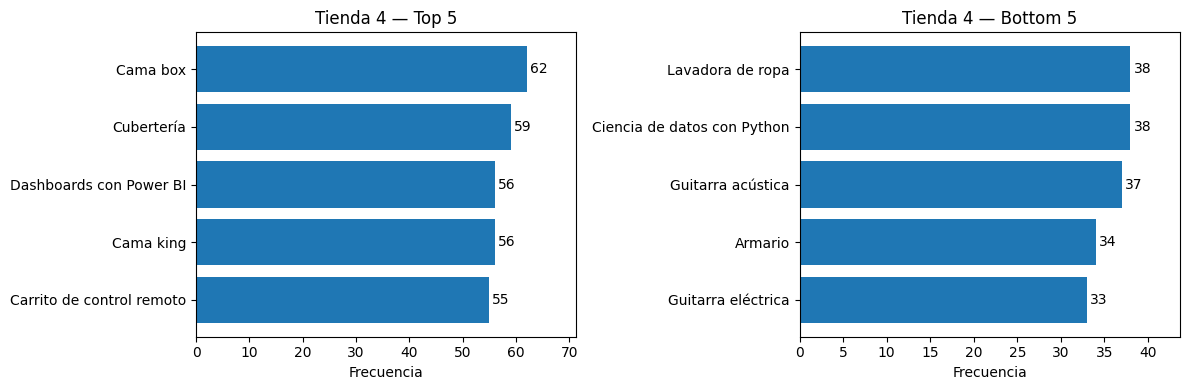

In [25]:

import matplotlib.pyplot as plt, os
os.makedirs("outputs", exist_ok=True)

def top_bottom(df, k=5):
    vc = df['Producto'].astype(str).str.strip().value_counts()
    k = min(k, len(vc))
    topk = vc.head(k).sort_values()
    bottomk = vc.sort_values().head(k)
    return topk, bottomk

# Por tienda: figura con 2 subplots (Top/Bottom)
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    top5, bottom5 = top_bottom(df, 5)
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].barh(top5.index, top5.values); axes[0].set_title(f"Tienda {i} — Top {len(top5)}"); axes[0].set_xlabel("Frecuencia")
    xmax = top5.values.max()*1.15 if len(top5) else 1; axes[0].set_xlim(0, xmax)
    for bar,val in zip(axes[0].containers[0], top5.values): axes[0].text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    axes[1].barh(bottom5.index, bottom5.values); axes[1].set_title(f"Tienda {i} — Bottom {len(bottom5)}"); axes[1].set_xlabel("Frecuencia")
    xb = bottom5.values.max()*1.15 if len(bottom5) else 1; axes[1].set_xlim(0, xb)
    for bar,val in zip(axes[1].containers[0], bottom5.values): axes[1].text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    plt.tight_layout(); plt.savefig(f"outputs/tienda_{i}_productos_top_bottom.png", bbox_inches="tight"); plt.show()


## 5) Costo promedio de envío por tienda

,Tienda,Costo_Envio_Promedio
0,Tienda 4,23459.457167
1,Tienda 3,24805.680373
2,Tienda 2,25216.235693
3,Tienda 1,26018.609580


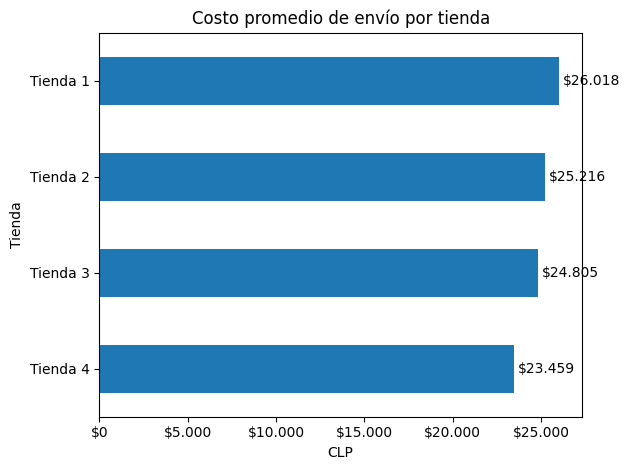

In [26]:

costos = []
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    prom_env = pd.to_numeric(df['Costo de envío'], errors='coerce').mean(skipna=True)
    costos.append({"Tienda": f"Tienda {i}", "Costo_Envio_Promedio": prom_env})

costos_envio = (pd.DataFrame(costos)
                .sort_values('Costo_Envio_Promedio')
                .reset_index(drop=True))
display(costos_envio)

# gráfico
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def clp_fmt(x, pos=None):
    try: return "$" + f"{int(x):,}".replace(",", ".")
    except: return x

fig, ax = plt.subplots()
(costos_envio.sort_values('Costo_Envio_Promedio')
 .plot(kind='barh', x='Tienda', y='Costo_Envio_Promedio', legend=False, ax=ax))
ax.set_title('Costo promedio de envío por tienda'); ax.set_xlabel('CLP'); ax.set_ylabel('Tienda')
ax.xaxis.set_major_formatter(FuncFormatter(clp_fmt))
for c in ax.containers: ax.bar_label(c, labels=[clp_fmt(v) for v in c.datavalues], label_type='edge', padding=3)
plt.tight_layout(); plt.savefig("outputs/costo_envio_promedio.png", bbox_inches="tight"); plt.show()

costos_envio.to_csv("outputs/costo_envio_promedio.csv", index=False)


## ✅ Conclusión y recomendación (breve)

**Criterios para decidir la tienda candidata a vender**  
1) Menor **facturación** y **ticket** (desempeño comercial).  
2) Menor **calificación** (satisfacción/retención).  
3) Mayor **costo de envío** (eficiencia logística).  


#> Interpretación: La tienda con score_vender más alto es la candidata más fuerte para ser vendida, pues combina menor desempeño comercial, menor satisfacción y/o mayor costo logístico. Aun así, me permito sugerir: complementar con variables estratégicas (contratos de arriendo, proyección de mercado, ubicación, personal, etc.) esta decisión.

> La interpretación final está en el README y puede ampliarse con variables cualitativas (contratos, ubicación, staff, proyección).  
> En el ANEXO se incluye un *score* opcional que integra estas dimensiones para priorizar la decisión.